# Project 3: Panoramic Mosaicing

### What to Submit
Submit this iPython Notebook--containing all your code for the programming exercises below--on [learning suite](https://learningsuite.byu.edu/).

Your notebook file should produce the relevant plots and also provide a short write-up with answers to the questions below.

Please also fill in here the time that each part took you:
* 1. Part A: <span style="color:red;">45 minutes</span>
* 2. Part B: <span style="color:red;">45 minutes using cv2.BFMatcher(), 2 hours manually</span>
* 3. Part C: <span style="color:red;">2 hours 30 minutes</span>
* 4. Part D: <span style="color:red;">5 hours (includes time spent on overall improvements)</span>
* 5. Write-up: <span style="color:red;">20 minutes</span>

### Programming Exercise

For this assignment, you will be writing a program that creates a panoramic mosaic from 2 or more images.  In general this technique should be applicable to any number of photographs.  The approach described below will work well for collective fields of up to 90 or even 120&deg;, but won't produce ideal results for large fields of view approaching or surpassing 180&deg;.  For large fields of view cylindrical or spherical projection is required.

When we construct a panorama, we assume that all of the photographs were taken from the exact same location and that the images are related by pure rotation (no translation of the camera).  The easiest way to create the panorama is to project all of the photos onto a plane.  One photo must be selected (either manually or by your program) to be the base photo.  The other photos are aligned to this base photo by identifying a homography (a planar warp specified by 4 pairs of source/destination points) relating each pair.  Each of the other images is appropriately warped and composited onto the plane (the base image doesn’t need to be warped).

In describing what you need to do, there will be a running example using the three photos below:


<div style="width:100%;text-align:center;"><img src="Images/example1.png" width=100%></div>
        

### Part A: Find Interest Points/Descriptors in each Input Image
We will be using OpenCV for this project, which you should already have installed.  However, you may need to install the contrib version--which comes seperate due to the SIFT algorithm being patented--by running the command:`pip install opencv-contrib-python`.  A good tutorial on how to use SIFT features in OpenCV is found [here](https://docs.opencv.org/trunk/da/df5/tutorial_py_sift_intro.html).  The first step to registering or aligning two images is to identify locations in each image that are distinctive or stand out.  The `sift.detectAndCompute()` routine produces both these interest points and their corresponding SIFT descriptors.  The first step of producing a panorama is to load all of the relevant images and find the interest points and their descriptors.

See the red circles on each image below indicating the sift keypoints that were found (note that we downsampled the images to 600 x 600 pixels before extracting SIFT).  We scaled the circles according to the scale at which each keypoint was detected at.

<div style="width:100%;text-align:center;"><img src="Images/example2.png" width=100%></div>

### Part B: Matching Features

Next, given the features present in each image, you need to match the features so as to determine corresponding points between adjacent/overlapping images.  [This page](https://docs.opencv.org/trunk/dc/dc3/tutorial_py_matcher.html) provides details to do feature matching using `cv2.BFMatcher()`, analogous to the approach proposed by David Lowe in his original implementation.  Be aware that the resulting match is one directional.  You want to find putative pairs--pairs of points which are each other’s best match (e.g. there might be 3 points in image I1 for which a point q in image I2 are the best match, only one of these could be the best matching point p in I1 for that point q in I2).  In this part you need to compute the set of putative matches between each pair of images.

Look at the pairs of images and the lines showing the estimated matches (putative matches are green lines, one way matches are cyan or blue).

<div style="width:100%;text-align:center;"><img src="Images/example3.png" width=100%></div>

### Part C: Estimating Pairwise Homographies using RANSAC

Use the RANSAC algorithm ([Szeliski](http://szeliski.org/Book/), Ch 6.1.4), estimate the homography between each pair of images.  You will need to decide whether you’re going to manually specify the base image or determine in programmatically.  Along with identifying the base image, you need to figure out the order in which you will composite the other images to the base.

You will need 4 pairs of points to estimate a homography.  Begin by randomly sampling sets of 4 pairs and estimating the corresponding homography for each set.  Instead of the two warping equations that we used earlier in the semester, it is recommended that you use a 3x3 homography (8 unknowns).  You are trying to estimate the homography

$$
\begin{bmatrix}a & b & c\\d & e & f\\g & h & 1\end{bmatrix}
$$

such that a point $(x_s,y_s)$ in the source image is tranformed to a point $(x_t,y_t)$ in the target image as follows

$$
\begin{bmatrix}x_t\\y_t\\1\end{bmatrix} = \begin{bmatrix}a & b & c\\d & e & f\\g & h & 1\end{bmatrix}\begin{bmatrix}x_s\\y_s\\1\end{bmatrix}
$$

Each pair of points will produce three linear equations in (a subset of) the 8 unknowns.  For example, $x_t = x_sa + y_sb + c$.  Four pairs of points (assuming no degeneracies) are sufficient to estimate the homography.  A more robust solution relying on more than four pairs can be obtained using least squares on the overconstrained linear system (solving $Ax = b$, where $x$ is a column vector with the 8 unknowns and you populate rows of $A$ and an entry of $b$ with the linear equations just described).  Note that this solution will **not** always be better.

Because of the homogeneous coordinates, the three equations can be reduced to two equations as follows:

$$
x_t = \frac{ax_s+by_s+c}{gx_s+hy_s+1}, \hspace{5mm}
y_t = \frac{dx_s+ey_s+f}{gx_s+hy_s+1}
$$

For more details, see the [image alignment and stitching slides](https://faculty.cs.byu.edu/~farrell/courses/CS450/slides/alignment_stitching.pdf#page=18).

Below you will find a visualization of the RANSAC estimated homographies.  Images 1, 2, and 3 have dots that are red, green and blue respectively (sorry the dots are a little small), representing the putative pairs.  You can see where the homographies line up very well and in a few places (the middle vertically) they line up slightly less well.

<div style="width:100%;text-align:center;"><img src="Images/example4.png" width=100%></div>

### Part D: Creating the Mosaic

Begin with the base image and warp the remaining images (using the estimated homographies) to composite them onto the base image.

For the ongoing campus example, here are the resulting warped images composited.

<div style="width:100%;text-align:center;"><img src="Images/example5.png" width=75%></div>

And, then with a very simple (but not ideal) compositing operation.

<div style="width:100%;text-align:center;"><img src="Images/example6.png" width=75%></div>

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import numpy as np # this is so that you can see which functions come from the numpy library
import matplotlib.pyplot as plt # this is so that you can see which functions come from the pyplot library
plt.rcParams['figure.figsize'] = [15,8]
plt.rcParams['axes.titlesize'] = '16'
plt.rcParams['axes.titleweight'] = 'bold'

import cv2
import time

def just_title(title):
    a = plt.gca()
    a.set_title(title, fontdict={'fontsize': rcParams['axes.titlesize'],
                                 'fontweight' : rcParams['axes.titleweight'],
                                 'verticalalignment': 'baseline',
                                 'horizontalalignment': 'center'})
    a.set_xticks([])
    a.set_yticks([])

### Part A: Find Interest Points/Descriptors

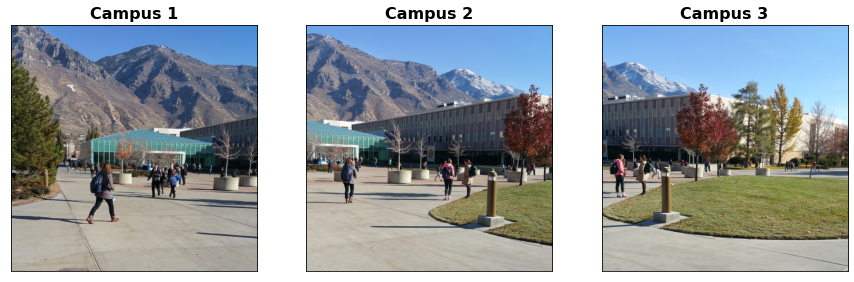

In [3]:
# Place Code Here

def get_img(image_path):
    im = cv2.imread(image_path)
#     im = cv2.resize(im[:2988,:,::-1], (600, 600), interpolation=cv2.INTER_LINEAR)
    return im[:,:,::-1]
    
im1 = get_img("Images/width600/campus1_sq600.png")
im2 = get_img("Images/width600/campus2_sq600.png")
im3 = get_img("Images/width600/campus3_sq600.png")

plt.subplot(131)
plt.imshow(im1)
just_title("Campus 1")

plt.subplot(132)
plt.imshow(im2)
just_title("Campus 2")

plt.subplot(133)
plt.imshow(im3)
just_title("Campus 3")

plt.show()

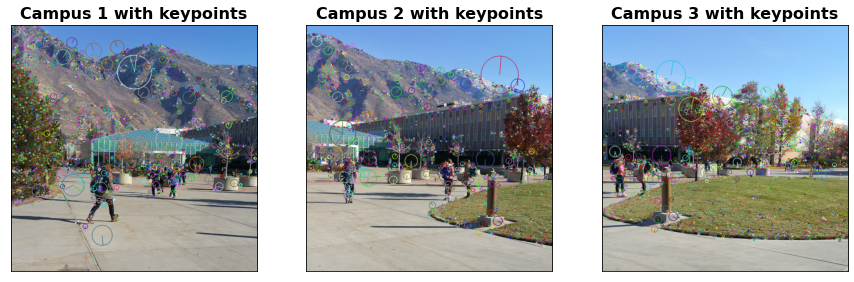

In [4]:
# Show an example output here

sift = cv2.SIFT_create()
kp1, des1 = sift.detectAndCompute(im1, None)
kp2, des2 = sift.detectAndCompute(im2, None)
kp3, des3 = sift.detectAndCompute(im3, None)

img1 = cv2.drawKeypoints(im1, kp1, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
img2 = cv2.drawKeypoints(im2, kp2, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
img3 = cv2.drawKeypoints(im3, kp3, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

plt.subplot(131)
plt.imshow(img1)
just_title("Campus 1 with keypoints")

plt.subplot(132)
plt.imshow(img2)
just_title("Campus 2 with keypoints")

plt.subplot(133)
plt.imshow(img3)
just_title("Campus 3 with keypoints")

plt.show()

### Part B: Matching Features

In [5]:
from tqdm import tqdm

class Match:
    def __init__(self, queryIdx, trainIdx, distance):
        self.queryIdx = queryIdx
        self.trainIdx = trainIdx
        self.distance = distance

def putative_match(des_1, des_2):
    distances = []  # distance matrix
    for d1 in tqdm(des_1):
        distance_row = []
        for d2 in des_2:
            distance_row.append(np.linalg.norm(d1-d2))
        distances.append(distance_row)
        
    distances = np.array(distances)
    
    vote_1 = np.argmin(distances, axis=1)
    vote_2 = np.argmin(distances, axis=0)
    
    final = []
    for i in range(len(vote_1)):
        if i == vote_2[vote_1[i]]:
            m = Match(i, vote_1[i], distances[i][vote_1[i]])
            final.append(m)
        
    return final

In [6]:
match_threshold = 150

matches12 = putative_match(des1, des2)
matches12 = sorted(matches12, key=lambda x:x.distance)
matches12 = filter(lambda match: match.distance < match_threshold, matches12)
matches12 = list(matches12)

matches23 = putative_match(des2, des3)
matches23 = sorted(matches23, key=lambda x:x.distance)
matches23 = filter(lambda match: match.distance < match_threshold, matches23)
matches23 = list(matches23)

matches13 = putative_match(des1, des3)
matches13 = sorted(matches13, key=lambda x:x.distance)
matches13 = filter(lambda match: match.distance < match_threshold, matches13)
matches13 = list(matches13)

100%|█████████████████████████████████████████████████████████████████████████████| 1989/1989 [00:16<00:00, 120.11it/s]


In [7]:
def draw_matches(image1, key_pts1, image2, key_pts2, matches12):
    joint_image = np.concatenate((image1, image2), axis=1)
    
    for match in matches12:
        pt1 = key_pts1[match.queryIdx].pt
        pt2 = key_pts2[match.trainIdx].pt
        pt1 = (int(pt1[0]), int(pt1[1]))
        pt2 = (int(image1.shape[1] + pt2[0]), int(pt2[1]))
        joint_image = cv2.line(joint_image, pt1, pt2, (0,255,0), 1)
    
    return joint_image

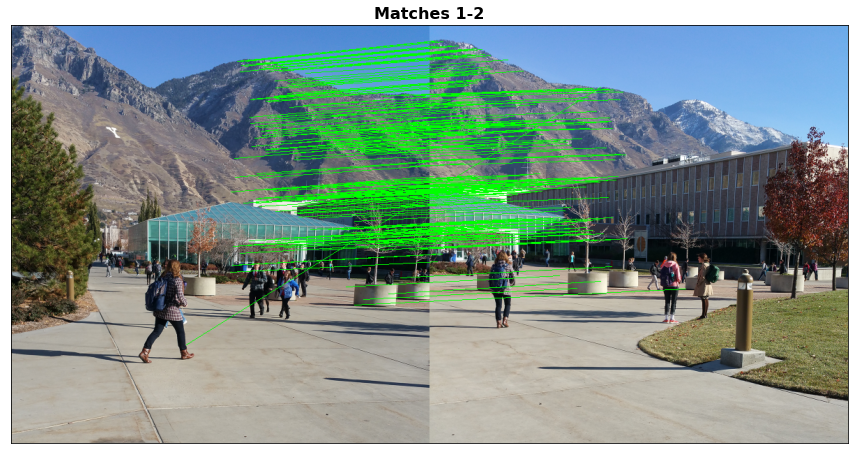

In [8]:
matches_image12 = draw_matches(im1, kp1, im2, kp2, matches12)

plt.imshow(matches_image12)
just_title("Matches 1-2")

plt.show()

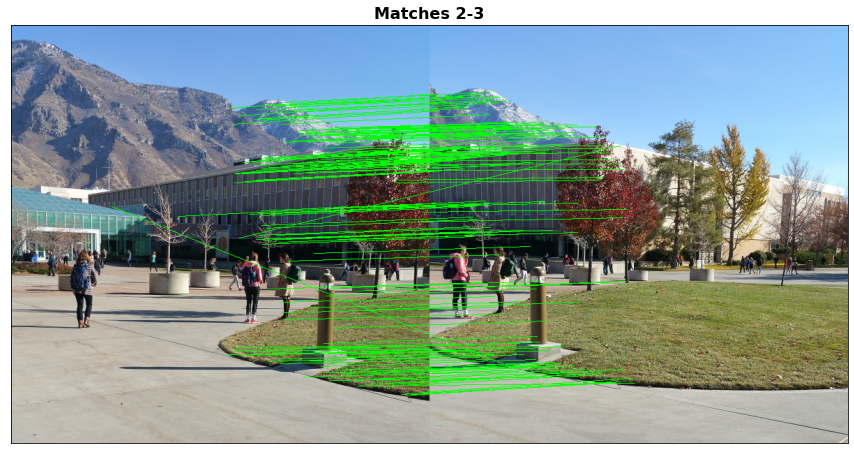

In [9]:
matches_image23 = draw_matches(im2, kp2, im3, kp3, matches23)

plt.imshow(matches_image23)
just_title("Matches 2-3")

plt.show()

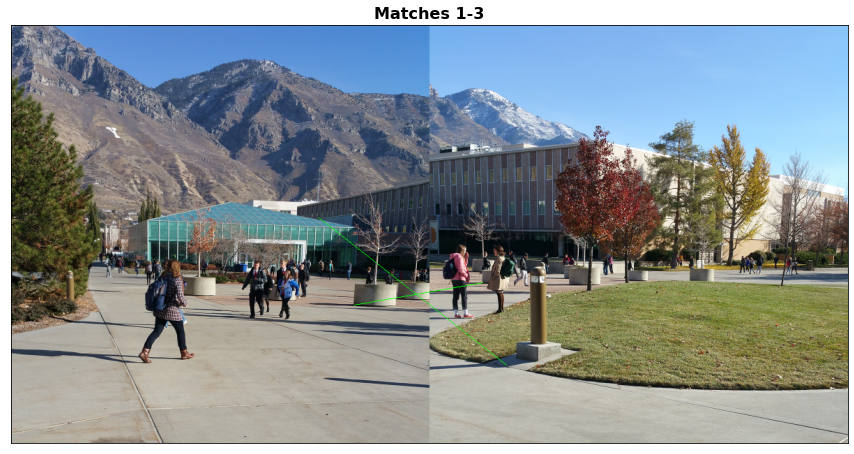

In [10]:
matches_image13 = draw_matches(im1, kp1, im3, kp3, matches13)

plt.imshow(matches_image13)
just_title("Matches 1-3")

plt.show()

### Part C: Estimating Pairwise Homographies using RANSAC

In [11]:
# Place Code Here

# Organize the lists of matches
new_matches12 = []
for match in matches12:
    p1 = kp1[match.queryIdx].pt
    p2 = kp2[match.trainIdx].pt
    new_matches12.append((p1, p2))
    
new_matches23 = []
for match in matches23:
    p1 = kp2[match.queryIdx].pt
    p2 = kp3[match.trainIdx].pt
    new_matches23.append((p1, p2))
    
new_matches13 = []
for match in matches13:
    p1 = kp1[match.queryIdx].pt
    p2 = kp3[match.trainIdx].pt
    new_matches13.append((p1, p2))

# Show an example output here
print("Matches between 1 and 2:", len(new_matches12))
print("Matches between 2 and 3:", len(new_matches23))
print("Matches between 1 and 3:", len(new_matches13))

Matches between 1 and 2: 210
Matches between 2 and 3: 165
Matches between 1 and 3: 2


In [12]:
# Automatic base selection
# The image with the most total matches is most likely the middle one

match_counts = []
match_counts.append(len(new_matches12) + len(new_matches13))  # count matches involving image 1
match_counts.append(len(new_matches12) + len(new_matches23))  # count matches involving image 2
match_counts.append(len(new_matches23) + len(new_matches13))  # count matches involving image 3

base_image_num = match_counts.index(max(match_counts))  # 0-indexed
print("Base image:", base_image_num+1)

Base image: 2


In [13]:
# to make the matrices for the four-point algorithm

def construct_matrices(points):
    A_matrix = []
    b_vector = []
    for ((x, y), (x_pr, y_pr)) in points:
        A_matrix.append([x, y, 1, 0, 0, 0, -1 * x_pr * x, -1 * x_pr * y])
        b_vector.append([x_pr])
        A_matrix.append([0, 0, 0, x, y, 1, -1 * y_pr * x, -1 * y_pr * y])
        b_vector.append([y_pr])
        
    return np.asarray(A_matrix), np.asarray(b_vector)

In [14]:
import random

def find_homography(matches, num_tries=1000, consensus_threshold=3.0, verbose=False):
    best_consensus_set = []
    for _ in range(num_tries):
        # find the four points
        sample_points = random.sample(matches, 4)
        
        # make the matrices
        A, b = construct_matrices(sample_points)
        
        # find the homography
        try:
            h_vector = np.linalg.solve(A, b)
        except LinAlgError as _:
            # thrown when the points are too linear (singular matrix error)
            continue
            
        # append 1 and turn vector into 3x3 matrix
        h_vector = np.append(h_vector, [[1.0]], axis=0)
        h = h_vector.reshape((3, 3))
        
        # test the homography and build consensus set
        consensus_set = []
        for ((x1, y1), (x2, y2)) in matches:
            p1 = np.array([[x1], [y1], [1.0]])
            p2_hat = np.matmul(h, p1)
            # normalize by the third vector element
            p2_hat = p2_hat / p2_hat[2][0]
            
            # check if p2 is close to p2_hat
            if abs(x2 - p2_hat[0][0]) < consensus_threshold and abs(y2 - p2_hat[1][0]) < consensus_threshold:
                consensus_set.append(((x1, y1), (x2, y2)))
        
        # keep largest consensus set
        if len(consensus_set) > len(best_consensus_set):
            best_consensus_set = consensus_set
    
    if verbose:
        print("Size of best consensus set:", len(best_consensus_set))
            
    if len(best_consensus_set) < 4:
        print("FINAL CONSENSUS SET TOO SMALL")
        return None
        
    # find a final homography using the entire consensus set and least-squares
    big_A, big_b = construct_matrices(best_consensus_set)
    final_h_vec = np.linalg.lstsq(big_A, big_b, rcond=None)
    
    # append 1 and turn vector into 3x3 matrix
    final_h_vec = np.append(final_h_vec[0], [[1.0]], axis=0)
    final_h = final_h_vec.reshape((3, 3))
    
    return final_h

In [15]:
if base_image_num == 0:
    homo1 = find_homography(new_matches12, num_tries=2000, verbose=True)
    homo1 = np.linalg.inv(homo1)  # now it is a homography from image 2 to 1
    homo2 = find_homography(new_matches13, num_tries=2000)
    homo2 = np.linalg.inv(homo2)  # now it is a homography from image 3 to 1
    images = [im1, im2, im3]  # base image first, then images in order of their homographies
elif base_image_num == 1:
    homo1 = find_homography(new_matches12, num_tries=2000, verbose=True)
    homo2 = find_homography(new_matches23, num_tries=2000, verbose=True)
    homo2 = np.linalg.inv(homo2)
    images = [im2, im1, im3]
elif base_image_num == 2:
    homo1 = find_homography(new_matches13, num_tries=2000, verbose=True)
    homo2 = find_homography(new_matches23, num_tries=2000, verbose=True)
    images = [im3, im1, im2]
else:
    print("SOMETHING IS WRONG")

Size of best consensus set: 208
Size of best consensus set: 141


### Part D: Creating the Mosaic

In [16]:
def apply_homography(point, homography):
    p = np.array([[point[0]], [point[1]], [1.0]])
    p_pr = np.matmul(homography, p)
    p_pr = p_pr / p_pr[2][0]
    
    return (p_pr[0][0], p_pr[1][0])

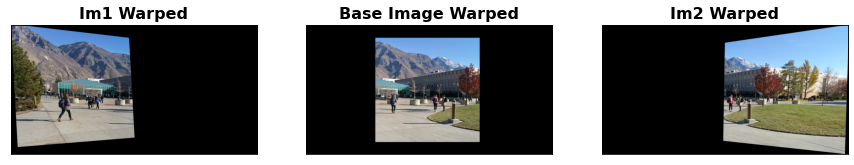

In [17]:
# Place Code Here

# initialize these values to our base image
min_x = 0
min_y = 0
max_x = images[0].shape[1]  # shape is height, width, channels
max_y = images[0].shape[0]

points = [(0, 0), (images[0].shape[1], 0), (0, images[0].shape[0]), (images[0].shape[1], images[0].shape[0])]

for homo in [homo1, homo2]:
    for point in points:
        new_pt = apply_homography(point, homo)
        if new_pt[0] < min_x: min_x = new_pt[0]
        if new_pt[0] > max_x: max_x = new_pt[0]
        if new_pt[1] < min_y: min_y = new_pt[1]
        if new_pt[1] > max_y: max_y = new_pt[1]

trans_mat = np.array([
    [1.0, 0, abs(min_x)],
    [0, 1.0, abs(min_y)],
    [0, 0, 1.0]
])
base_homo = trans_mat
homo1 = np.matmul(trans_mat, homo1)
homo2 = np.matmul(trans_mat, homo2)

window_size = (int(max_x-min_x), int(max_y-min_y))

base_im_warped = cv2.warpPerspective(images[0], base_homo, window_size)
im1_warped = cv2.warpPerspective(images[1], homo1, window_size)
im2_warped = cv2.warpPerspective(images[2], homo2, window_size)


# Show an example output here

plt.subplot(131)
plt.imshow(im1_warped)
just_title("Im1 Warped")

plt.subplot(132)
plt.imshow(base_im_warped)
just_title("Base Image Warped")

plt.subplot(133)
plt.imshow(im2_warped)
just_title("Im2 Warped")

plt.show()

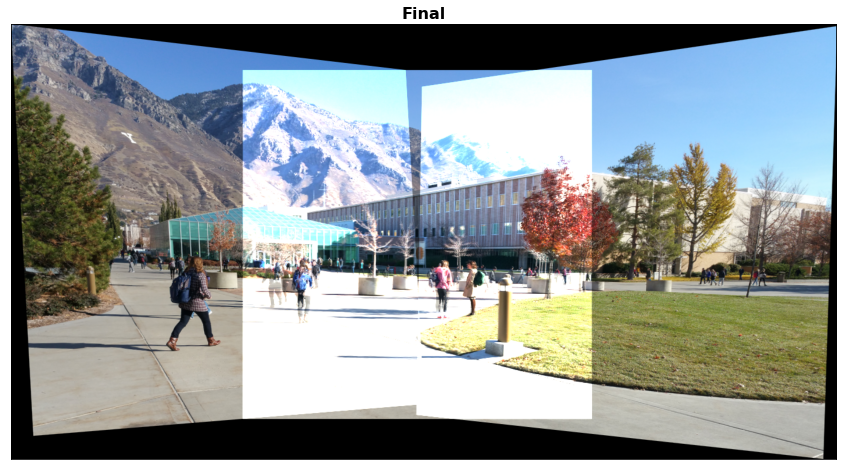

In [18]:
dst = cv2.addWeighted(base_im_warped, 1, im1_warped, 1, 0)
dst = cv2.addWeighted(dst, 1, im2_warped, 1, 0)

plt.imshow(dst)
just_title("Final")

plt.show()

### Final Results and Improvements

In [19]:
# Output results for additional images here
# Feel free to add as many cells as you wish
# takes a while for some reason
from tqdm import tqdm

def composite(image1, image2):
    # image1 and image2 should be the same size and shape
    assert image1.shape == image2.shape
    
    new_image = np.zeros(image1.shape, dtype=np.uint8)
    
    for i in tqdm(range(len(new_image))):
        for j in range(len(new_image[i])):
            if np.array_equal(image1[i][j], [0, 0, 0]):
                new_image[i][j] = image2[i][j]
            elif np.array_equal(image2[i][j], [0, 0, 0]):
                new_image[i][j] = image1[i][j]
            else:
                new_image[i][j] = np.mean((image1[i][j], image2[i][j]), axis=0)
    
    return new_image
    
result = composite(base_im_warped, im1_warped)
result = composite(result, im2_warped)

100%|████████████████████████████████████████████████████████████████████████████████| 748/748 [00:12<00:00, 60.51it/s]


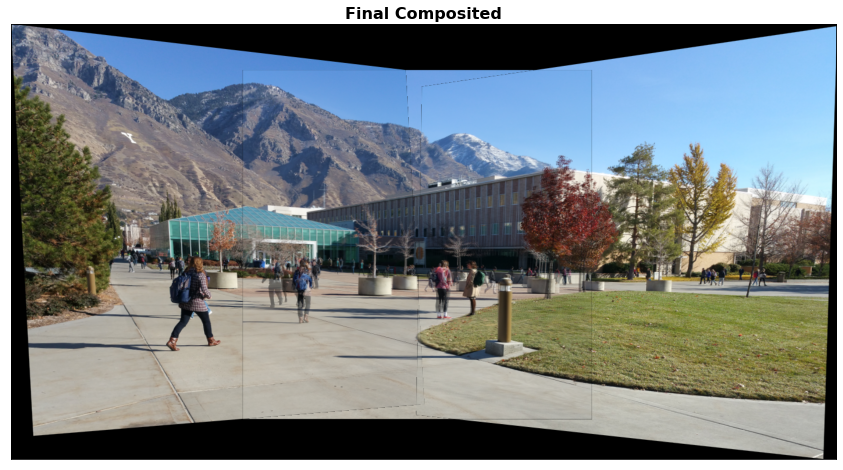

In [20]:
# blurred = cv2.GaussianBlur(result, (3,3), 0)

plt.imshow(result)
just_title("Final Composited")

plt.show()

# ONE CODE TO RULE THEM ALL 
### (some of the earlier cells will still have to be run first...)

In [21]:
# CODE TO DO IT ALL!!
import time

def stitch_images(image1, image2, image3):
    time1 = time.time()
    
    # LOAD POINTS
    print("Loading points...")
    
    im1 = cv2.imread(image1)
    im1 =  im1[:,:,::-1]
    
    im2 = cv2.imread(image2)
    im2 =  im2[:,:,::-1]
    
    im3 = cv2.imread(image3)
    im3 =  im3[:,:,::-1]
    
    #################################### PART A
    print("Starting Part A...")
    
    sift = cv2.SIFT_create()
    kp1, des1 = sift.detectAndCompute(im1, None)
    kp2, des2 = sift.detectAndCompute(im2, None)
    kp3, des3 = sift.detectAndCompute(im3, None)
    
    #################################### PART B
    print("Starting Part B...")
    
    match_threshold = 150

    time.sleep(0.5)
    matches12 = putative_match(des1, des2)
    matches12 = sorted(matches12, key=lambda x:x.distance)
    matches12 = filter(lambda match: match.distance < match_threshold, matches12)
    matches12 = list(matches12)

    matches23 = putative_match(des2, des3)
    matches23 = sorted(matches23, key=lambda x:x.distance)
    matches23 = filter(lambda match: match.distance < match_threshold, matches23)
    matches23 = list(matches23)

    matches13 = putative_match(des1, des3)
    matches13 = sorted(matches13, key=lambda x:x.distance)
    matches13 = filter(lambda match: match.distance < match_threshold, matches13)
    matches13 = list(matches13)
    time.sleep(0.5)
    
    #################################### PART C
    print("Starting Part C...")
    
    new_matches12 = []
    for match in matches12:
        p1 = kp1[match.queryIdx].pt
        p2 = kp2[match.trainIdx].pt
        new_matches12.append((p1, p2))

    new_matches23 = []
    for match in matches23:
        p1 = kp2[match.queryIdx].pt
        p2 = kp3[match.trainIdx].pt
        new_matches23.append((p1, p2))

    new_matches13 = []
    for match in matches13:
        p1 = kp1[match.queryIdx].pt
        p2 = kp3[match.trainIdx].pt
        new_matches13.append((p1, p2))
        
    match_counts = []
    match_counts.append(len(new_matches12) + len(new_matches13))  # count matches involving image 1
    match_counts.append(len(new_matches12) + len(new_matches23))  # count matches involving image 2
    match_counts.append(len(new_matches23) + len(new_matches13))  # count matches involving image 3

    base_image_num = match_counts.index(max(match_counts))  # 0-indexed
    
    if base_image_num == 0:
        homo1 = find_homography(new_matches12, num_tries=2000)
        homo1 = np.linalg.inv(homo1)  # now it is a homography from image 2 to 1
        homo2 = find_homography(new_matches13, num_tries=2000)
        homo2 = np.linalg.inv(homo2)  # now it is a homography from image 3 to 1
        images = [im1, im2, im3]  # base image first, then images in order of their homographies
    elif base_image_num == 1:
        homo1 = find_homography(new_matches12, num_tries=2000)
        homo2 = find_homography(new_matches23, num_tries=2000)
        homo2 = np.linalg.inv(homo2)
        images = [im2, im1, im3]
    elif base_image_num == 2:
        homo1 = find_homography(new_matches13, num_tries=2000)
        homo2 = find_homography(new_matches23, num_tries=2000)
        images = [im3, im1, im2]
    else:
        print("SOMETHING IS WRONG")
    
    #################################### PART D
    print("Starting Part D...")
    
    min_x = 0
    min_y = 0
    max_x = images[0].shape[1]  # shape is height, width, channels
    max_y = images[0].shape[0]

    points = [(0, 0), (images[0].shape[1], 0), (0, images[0].shape[0]), (images[0].shape[1], images[0].shape[0])]

    for homo in [homo1, homo2]:
        for point in points:
            new_pt = apply_homography(point, homo)
            if new_pt[0] < min_x: min_x = new_pt[0]
            if new_pt[0] > max_x: max_x = new_pt[0]
            if new_pt[1] < min_y: min_y = new_pt[1]
            if new_pt[1] > max_y: max_y = new_pt[1]

    trans_mat = np.array([
        [1.0, 0, abs(min_x)],
        [0, 1.0, abs(min_y)],
        [0, 0, 1.0]
    ])
    base_homo = trans_mat
    homo1 = np.matmul(trans_mat, homo1)
    homo2 = np.matmul(trans_mat, homo2)

    window_size = (int(max_x-min_x), int(max_y-min_y))

    base_im_warped = cv2.warpPerspective(images[0], base_homo, window_size)
    im1_warped = cv2.warpPerspective(images[1], homo1, window_size)
    im2_warped = cv2.warpPerspective(images[2], homo2, window_size)
    
    #################################### PREPPING OUTPUT
    print("Finalizing result...")
    
    time.sleep(0.5)
    result = composite(base_im_warped, im1_warped)
    result = composite(result, im2_warped)
    time.sleep(0.5)
    
    print(f"Finished in {round(time.time()-time1, 2)} seconds!")
    return result

In [22]:
first_image = "Images/width600/campus1_sq600.png"
second_image = "Images/width600/campus2_sq600.png"
third_image = "Images/width600/campus3_sq600.png"
campus = stitch_images(first_image, second_image, third_image)

Loading points...
Starting Part A...
Starting Part B...


100%|█████████████████████████████████████████████████████████████████████████████| 1989/1989 [00:16<00:00, 121.89it/s]


Starting Part C...
Starting Part D...
Finalizing result...


100%|████████████████████████████████████████████████████████████████████████████████| 748/748 [00:13<00:00, 55.54it/s]


Finished in 74.59 seconds!


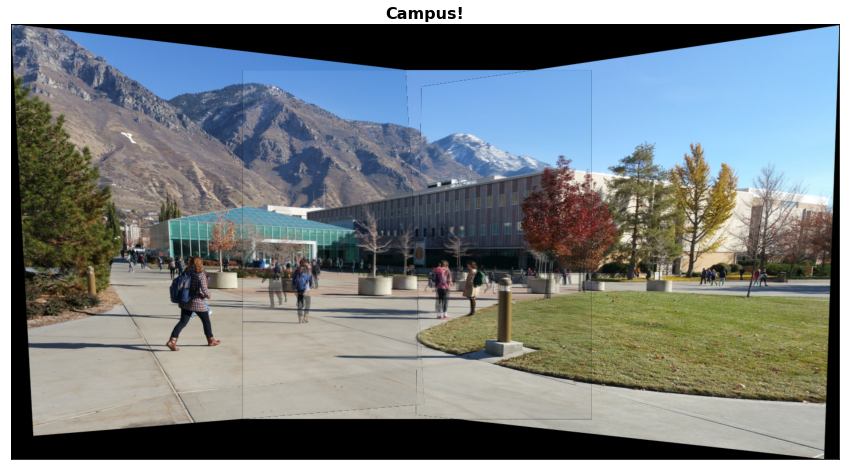

In [23]:
plt.imshow(campus)
just_title("Campus!")

plt.show()

In [24]:
first_image = "Images/width600/squaw_peak3_sq600.png"
second_image = "Images/width600/squaw_peak1_sq600.png"
third_image = "Images/width600/squaw_peak2_sq600.png"
squaw_peak = stitch_images(first_image, second_image, third_image)

Loading points...
Starting Part A...
Starting Part B...


100%|███████████████████████████████████████████████████████████████████████████████| 689/689 [00:04<00:00, 144.41it/s]


Starting Part C...
Starting Part D...
Finalizing result...


100%|████████████████████████████████████████████████████████████████████████████████| 769/769 [00:11<00:00, 66.32it/s]


Finished in 49.9 seconds!


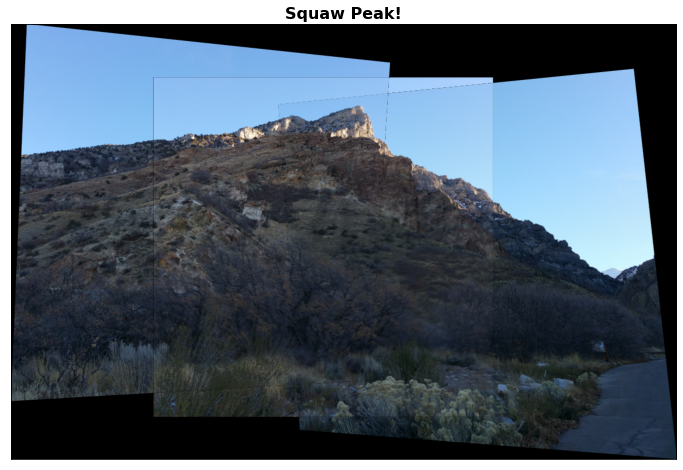

In [25]:
plt.imshow(squaw_peak)
just_title("Squaw Peak!")

plt.show()

In [26]:
first_image = "Images/width600/temple_horiz2_sq600.png"
second_image = "Images/width600/temple_horiz3_sq600.png"
third_image = "Images/width600/temple_horiz1_sq600.png"
temple_horiz = stitch_images(first_image, second_image, third_image)

Loading points...
Starting Part A...
Starting Part B...


100%|█████████████████████████████████████████████████████████████████████████████| 1194/1194 [00:08<00:00, 137.39it/s]


Starting Part C...
Starting Part D...
Finalizing result...


100%|████████████████████████████████████████████████████████████████████████████████| 803/803 [00:14<00:00, 56.59it/s]


Finished in 53.17 seconds!


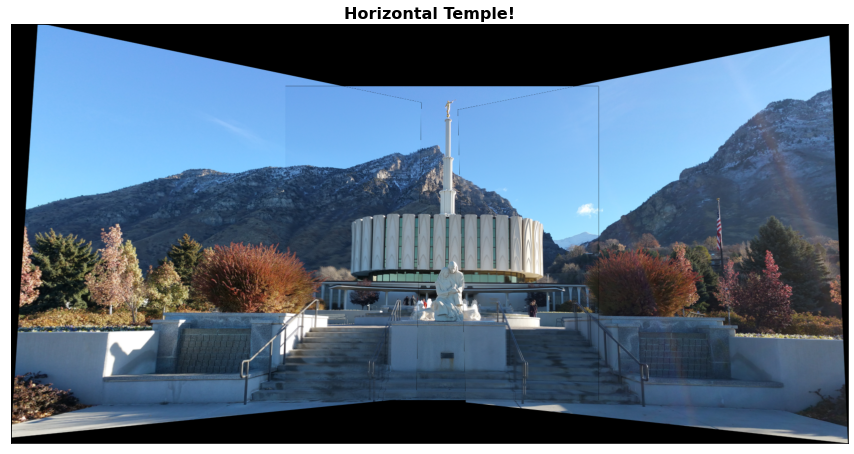

In [27]:
plt.imshow(temple_horiz)
just_title("Horizontal Temple!")

plt.show()

In [28]:
first_image = "Images/width600/temple_vertical3_sq600.png"
second_image = "Images/width600/temple_vertical2_sq600.png"
third_image = "Images/width600/temple_vertical1_sq600.png"
temple_vertical = stitch_images(first_image, second_image, third_image)

Loading points...
Starting Part A...
Starting Part B...


100%|███████████████████████████████████████████████████████████████████████████████| 496/496 [00:02<00:00, 216.06it/s]


Starting Part C...
Starting Part D...
Finalizing result...


100%|█████████████████████████████████████████████████████████████████████████████| 1401/1401 [00:12<00:00, 110.76it/s]


Finished in 39.58 seconds!


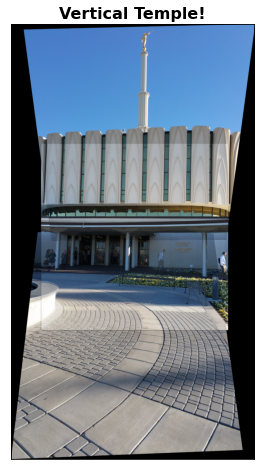

In [29]:
plt.imshow(temple_vertical)
just_title("Vertical Temple!")

plt.show()

### Grading

To get 100% you need to (i) implement RANSAC and additionally (ii) either implement the feature matching yourself (instead of using built-in matching functions such as `cv2.BFMatcher()`), or incorporate one of the following improvements:
* A nice clean compositing/blending approach so that edges/artifacts are not noticeable.
* Automatic selection of which image should be the base
* Handling more than 3 photos
* Another enhancement approved by Dr. Farrell

Points for this assigment will be assigned as follows (100 points total):
* [10 pts] Extracting features from both images (interest points and descriptors).
* [20 pts] Four-point algorithm to estimate homographies.
* [30 pts] RANSAC implemented (partial points given for poor alignments).
* [20 pts] Images warped appropriately (aligning on top of each other).
* [10 pts] Clean final image (extents of merged image should fit the enscribed rectangle).
* [10 pts] Implementing matching or other improvement (see above). Bonus points may be given for additional enhancements.

## Write-up:
Provide an explanation for the following items:
* In what scenarios was it difficult to get good alignments between images?
* If you have any suggestions for how to improve this project in the future, list them here.

<span style="color:red;">For me, it looks like I was able to get good alignments between all the images. I'm sure it would be tough if the overlapping region between images was smaller. Also, it would be tougher if the objects were more repetitive (less unique features).</span>

<span style="color:red;">I had two improvements. First, I implemented automatic base selection. For proof that this works, note how images in my examples are in different orders. Like, sometimes the third (right-most) image is 'first_image' and so on.</span>

<span style="color:red;">I originally used the BFMatcher. But then I went back and implemented my own feature matching functionality, just for fun. You can see I don't call BFMatcher at all now. Hopefully I can get some bonus points for that too... (>'.')></span>

<span style="color:red;">My only suggestion would be to make everyone do the same improvement(s), but I also think it's fine how it is. It was super fun!</span>